In [1]:
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, BertTokenizer
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import itertools
import numpy as np
from transformers import BertModel
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import re
from sklearn.metrics import confusion_matrix
from om.ont import tokenize, get_n
from rdflib import Graph
from rdflib.term import BNode, URIRef, Literal
from rdflib.namespace import RDF, RDFS, SKOS, OWL
from collections import Counter
from om.match import onts, aligns
from rdflib.plugins.serializers.nt import _nt_row
from rdflib.plugins.parsers.ntriples import W3CNTriplesParser, NTGraphSink, codecs, ParseError
from rdflib.plugins.parsers.rdfxml import RDFXMLParser
import json
import numpy as np
from ridgeplot import ridgeplot
from ridgeplot.datasets import load_probly
import plotly.express as px

import matplotlib as mpl
import matplotlib.gridspec as grid_spec

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
class TestSink(NTGraphSink):

    def __init__(self):
        self.g = Graph()
        super().__init__(self.g)

    def triple(self, s, p, o):
        if type(o) is Literal and o.language not in {'en', None}:
            return
        if p not in {RDF.type, RDFS.label, SKOS.prefLabel, SKOS.altLabel, RDFS.comment}:
            return

        self.g.add((s, p, o))


class SkipParser(W3CNTriplesParser):

    def lg(self, p):
        sink = TestSink()
        n = SkipParser(sink)

        with open(p, 'r') as f:
            n.parse(f)

        return sink.g

    def parse(self, f, bnode_context=None):

        if not hasattr(f, "read"):
            raise ParseError("Item to parse must be a file-like object.")

        if not hasattr(f, "encoding") and not hasattr(f, "charbuffer"):
            # someone still using a bytestream here?
            f = codecs.getreader("utf-8")(f)

        self.file = f
        self.buffer = ""
        while True:

            self.line = self.readline()

            if self.line is None:
                break
            try:
                self.parseline(bnode_context=bnode_context)
            except ParseError:
                continue

        return self.sink

In [13]:
class NoLabelFoundException(Exception):
    pass


def get_label(e, g):
    vl = [g.value(e, RDFS.label), g.value(e, SKOS.prefLabel), g.value(e, SKOS.altLabel),
          get_n(e, g)]

    lb = list(filter(lambda x: x is not None, vl))

    if len(lb) <= 0:
        raise NoLabelFoundException()

    lb = lb[0]

    if lb is None or 'None' in lb:
        raise NoLabelFoundException()

    if len(lb) > 200:
        lb = lb[:200]

    return ' '.join(tokenize(lb)).lower()

In [14]:
def is_property(e, g):
    types = list(g.objects(e, RDF.type))
    tn = map(lambda x: get_n(x, g), types)
    have_prop = map(lambda x: 'property' in x.lower(), tn)

    return any(have_prop)

def get_ld(bp):
    lc = Counter()
    sbj_count = 0
    ld = {}
    lnd = Counter()

    for p, d, fs in os.walk(bp):

        for f in fs:
            if not f.endswith('.owl') and not f.endswith('.rdf') and not f.endswith('.nt'):
                continue

            path = f'{p}/{f}'

            if f.endswith('.nt'):
                g = SkipParser().lg(path)
            else:
                try:
                    g = Graph().parse(path)
                except:

                    continue

            sbj = set(g.subjects())
            objs = set()

            for s in sbj:
                if type(s) is BNode or s.startswith('http://www.w3') or is_property(s, g):
                    continue
                sbj_count += 1
                for _, pr, o in g.triples((s, None, None)):
                    if (pr, o.strip()) in objs:
                        continue
                    if pr not in {RDFS.label, SKOS.prefLabel, SKOS.altLabel, RDFS.comment}:
                        continue
                    lc[pr] += 1
                    objs.add((pr, o.strip()))
                    ld.setdefault(pr, Counter())[len(o.strip())] += 1

                try:
                    label = get_label(s, g)
                    lnd[len(label)] += 1
                except:
                    continue
        break

    return sbj_count, lc, ld, lnd


In [ ]:
data = {}


for bp in tqdm([
    '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts',
    '/projets/melodi/gsantoss/data/oaei/tracks/anatomy/onts',
    '/projets/melodi/gsantoss/data/oaei/tracks/complex/ontology',
    '/projets/melodi/gsantoss/data/oaei/tracks/food-nc',
    '/projets/melodi/gsantoss/data/oaei/tracks/bio-ml/MONDO/equiv_match/ontos',
    '/projets/melodi/gsantoss/data/oaei/tracks/bio-ml/UMLS/equiv_match/ontos',
    '/projets/melodi/gsantoss/data/oaei/tracks/biodiv/ncbitaxon-taxref-modules',
    '/projets/melodi/gsantoss/data/oaei/tracks/biodiv/onts',
    '/projets/melodi/gsantoss/data/oaei/tracks/MSE-Benchmark/testCases/onts',
    '/projets/melodi/gsantoss/data/oaei/tracks/ikg/onts'
]):
    data[bp] = get_ld(bp)

with open('/projets/melodi/gsantoss/tmp/label-dist.json', 'w') as f:
    json.dump(data, f)

  0%|          | 0/10 [00:00<?, ?it/s]

Failed to convert Literal lexical form to value. Datatype=http://www.w3.org/2001/XMLSchema#dateTime, Converter=<function parse_datetime at 0x7fd5859328c0>
Traceback (most recent call last):
  File "/projets/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.10/site-packages/isodate/isodatetime.py", line 51, in parse_datetime
    datestring, timestring = datetimestring.split('T')
ValueError: not enough values to unpack (expected 2, got 1)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/projets/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.10/site-packages/rdflib/term.py", line 2084, in _castLexicalToPython
    return conv_func(lexical)  # type: ignore[arg-type]
  File "/projets/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.10/site-packages/isodate/isodatetime.py", line 53, in parse_datetime
    raise ISO8601Error("ISO 8601 time designator 'T' missing. Unable to"
isodate.isoerror.ISO8601Error: ISO 8601 time designat

In [10]:
with open('/projets/melodi/gsantoss/tmp/label-dist.json', 'r') as f:
    data = json.load(f)

In [26]:
res = []

lm = {str(RDFS.label): 0, str(SKOS.prefLabel): 1, str(SKOS.altLabel): 2, str(RDFS.comment): 3}

dists = {}

for k, v in data.items():
    sbc, lc, ld, lnd = v
    counts = [0] * len(lm)
    for c in lc.keys():
        counts[lm[c]] = lc[c]

    res.append([k, sbc] + counts)
    dists[k] = ld


rd = pd.DataFrame(res, columns=['track', 'entities', 'rdfs.label', 'skos.prefLabel', 'skos.altLabel', 'rdfs.comment'])

rd

track  entities  rdfs.label  \
0  /projets/melodi/gsantoss/data/oaei/tracks/conf...      1020           0   
1  /projets/melodi/gsantoss/data/oaei/tracks/anat...     12498       12017   
2  /projets/melodi/gsantoss/data/oaei/tracks/comp...     32620        9565   
3  /projets/melodi/gsantoss/data/oaei/tracks/food-nc     11737           0   
4  /projets/melodi/gsantoss/data/oaei/tracks/bio-...     34872       33755   
5  /projets/melodi/gsantoss/data/oaei/tracks/bio-...    145486      145093   
6  /projets/melodi/gsantoss/data/oaei/tracks/biod...    233776      233746   
7  /projets/melodi/gsantoss/data/oaei/tracks/biod...   3599317     2582980   
8  /projets/melodi/gsantoss/data/oaei/tracks/MSE-...      2411         953   
9  /projets/melodi/gsantoss/data/oaei/tracks/ikg/...   2050682      808385   

   skos.prefLabel  skos.altLabel  rdfs.comment  
0               0              0            32  
1               0              0             0  
2               0              0           434  
3            9396              0             0  
4               0              0            60  
5           55312          23948            43  
6               0           5861             0  
7          359314         155987           882  
8             451             47           872  
9          321695         708059        276631

In [27]:
ds5 = pd.read_csv('./top_domain/ds5.csv')
ds5.head()

label                                        description  \
0            johnnycake  cornbread usually cooked pancake-style on a gr...   
1           johnny cake  cornbread usually cooked pancake-style on a gr...   
2          journey cake  cornbread usually cooked pancake-style on a gr...   
3  paper chromatography  chromatography that uses selective adsorption ...   
4            hemiplegic  a person who has hemiplegia (is paralyzed on o...   

       class  
0   endurant  
1   endurant  
2   endurant  
3  perdurant  
4   endurant

In [28]:
dsc = {}



for l, d, c in ds5.itertuples(index=None, name=None):
    dsc.setdefault(str(RDFS.label), Counter())[len(d)] += 1
    dsc.setdefault(str(SKOS.prefLabel), Counter())[len(d)] += 1
    dsc.setdefault(str(SKOS.altLabel), Counter())[len(d)] += 1
    dsc.setdefault(str(RDFS.comment), Counter())[len(d)] += 1


In [99]:
mv = -1

for k, v in dists.items():

    for l, c in v.items():
        if max(c.keys()) > mv:
            mv = max(c.keys())

TypeError: '>' not supported between instances of 'str' and 'int'

In [67]:
mv += 1

In [34]:
dv = {}
dists['ds5'] = dsc
mv = 400
for k, v in dists.items():
    current_dist = [[0] * mv, [0] * mv, [0] * mv, [0] * mv]
    for l, c in v.items():
        for q, w in c.items():
            q = int(q)
            if q >= mv:
                continue
            current_dist[lm[l]][q] = w / max(c.values())
    dv[k] = current_dist




In [210]:
print(dv.keys())

dict_keys(['/projets/melodi/gsantoss/data/oaei/tracks/conference/onts', '/projets/melodi/gsantoss/data/oaei/tracks/anatomy/onts', '/projets/melodi/gsantoss/data/oaei/tracks/complex/ontology', '/projets/melodi/gsantoss/data/oaei/tracks/food-nc', '/projets/melodi/gsantoss/data/oaei/tracks/bio-ml/MONDO/equiv_match/ontos', '/projets/melodi/gsantoss/data/oaei/tracks/bio-ml/UMLS/equiv_match/ontos', '/projets/melodi/gsantoss/data/oaei/tracks/biodiv/ncbitaxon-taxref-modules', '/projets/melodi/gsantoss/data/oaei/tracks/biodiv/onts', '/projets/melodi/gsantoss/data/oaei/tracks/MSE-Benchmark/testCases/onts', '/projets/melodi/gsantoss/data/oaei/tracks/ikg/onts', 'ds5'])


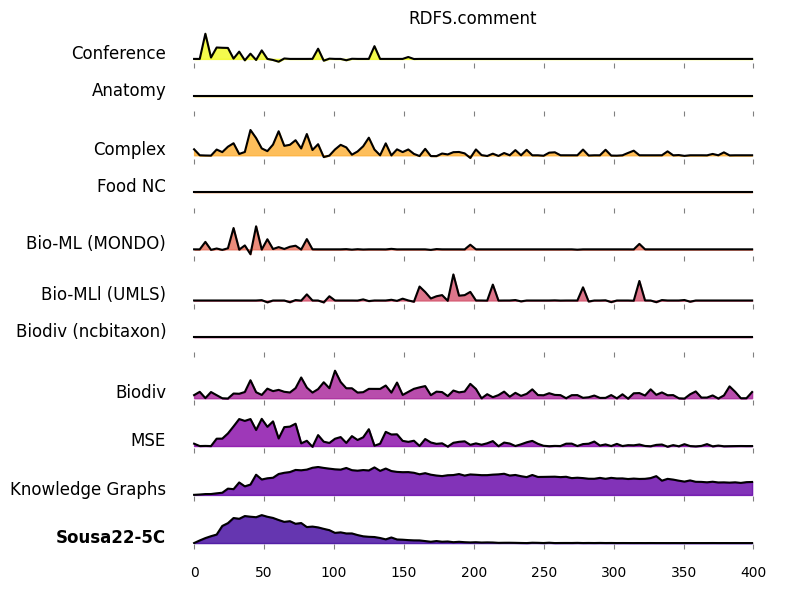

In [112]:
from scipy.interpolate import make_interp_spline, BSpline


name_map = {
    '/projets/melodi/gsantoss/data/oaei/tracks/conference/onts': 'Conference',
    '/projets/melodi/gsantoss/data/oaei/tracks/anatomy/onts': 'Anatomy',
    '/projets/melodi/gsantoss/data/oaei/tracks/complex/ontology': 'Complex',
    '/projets/melodi/gsantoss/data/oaei/tracks/food-nc': 'Food NC',
    '/projets/melodi/gsantoss/data/oaei/tracks/bio-ml/MONDO/equiv_match/ontos': 'Bio-ML (MONDO)',
    '/projets/melodi/gsantoss/data/oaei/tracks/bio-ml/UMLS/equiv_match/ontos': 'Bio-MLl (UMLS)',
    '/projets/melodi/gsantoss/data/oaei/tracks/biodiv/ncbitaxon-taxref-modules': 'Biodiv (ncbitaxon)',
    '/projets/melodi/gsantoss/data/oaei/tracks/biodiv/onts': 'Biodiv',
    '/projets/melodi/gsantoss/data/oaei/tracks/MSE-Benchmark/testCases/onts': 'MSE',
    '/projets/melodi/gsantoss/data/oaei/tracks/ikg/onts': 'Knowledge Graphs',
    'ds5': 'Sousa22-5C'
}

gs = grid_spec.GridSpec(len(dv),2)

fig = plt.figure(figsize=(8,6))

i = 0

#creating empty list
ax_objs = []


for k, v in dv.items():
    # creating new axes object and appending to ax_objs
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))


    h = np.array(v[3])
    x = np.array(list(range(len(h))))

    xnew = np.linspace(x.min(), x.max(), 100)

    spl = make_interp_spline(x, h, k=3)  # type: BSpline
    power_smooth = spl(xnew)

    # filling the space beneath the distribution

    ax_objs[-1].plot(xnew, power_smooth, color='black')
    ax_objs[-1].fill_between(xnew, power_smooth,color=mpl.colormaps['plasma'](1 - i/len(dv)), alpha=0.8)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    ax_objs[-1].set_yticklabels([])
    ax_objs[-1].set_ylabel(None)
    ax_objs[-1].get_yaxis().set_visible(False)
    if i == len(dv)-1:
        pass
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    ax_objs[-1].text(-20,0,name_map[k],fontsize=12,ha="right", weight='bold' if k == 'ds5' else None)
    ax_objs[-1].tick_params(axis='x', which='both', color='grey', pad=12)
    i += 1

#RDFS.label, SKOS.prefLabel, SKOS.altLabel, RDFS.comment
ax_objs[0].set_title('RDFS.comment')
# gs.update(hspace=-0.2)
plt.tight_layout()
plt.savefig('./top_domain/figs/rdfscomment.png', dpi=150)
plt.show()

In [175]:
# Load the probly dataset
df = load_probly()

# Let's grab only the subset of columns displayed in the example
column_names = [
    "Almost Certainly", "Very Good Chance", "We Believe", "Likely",
    "About Even", "Little Chance", "Chances Are Slight", "Almost No Chance",
]  # fmt: skip
df = df[column_names]

# Not only does 'ridgeplot(...)' come configured with sensible defaults
# but is also fully configurable to your own style and preference!
fig = ridgeplot(
    samples=df.values.T,
    bandwidth=4,
    kde_points=np.linspace(-12.5, 112.5, 400),
    colorscale="viridis",
    colormode="index",
    coloralpha=0.6,
    labels=column_names,
    spacing=5 / 9,
)

# Again, update the figure layout to your liking here
fig.update_layout(
    title="What probability would you assign to the phrase <i>“Highly likely”</i>?",
    height=650,
    width=800,
    plot_bgcolor="rgba(255, 255, 255, 0.0)",
    xaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_gridcolor="rgba(0, 0, 0, 0.1)",
    yaxis_title="Assigned Probability (%)",
)
fig.show()

In [176]:
# Put your real samples here...
np.random.seed(0)
synthetic_samples = [np.random.normal(n / 1.2, size=600) for n in range(9, 0, -1)]

# Call the `ridgeplot()` helper, packed with sensible defaults
fig = ridgeplot(samples=synthetic_samples)

# The returned Plotly `Figure` is still fully customizable
fig.update_layout(height=500, width=800)

# show us the work!
fig.show()